# Introduction
In this notebook, we show how to run the experiment corresponding to Figure 3 in our paper.
We only present one case here, but one can repeat the same for 100 times to obtain the results in the paper.

## Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

from frp.graph_utils import plot_graph
from frp.sem_utils import generate_random_data_from_graph

from dglearn.evaluation.evaluation_kld import minimize_kld

from run_causal_discovery import run_filter_rank_prune, run_dglearn

## Ground Truth Generation

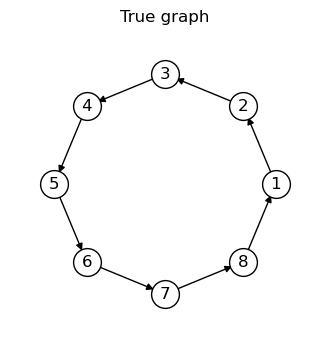

In [2]:
seed = 0
graph_true = ig.Graph.Formula("1->2->3->4->5->6->7->8->1")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_graph(ax, graph_true, 
              labels={v: f"{v+1}" for v in range(len(graph_true.vs))})
ax.set_title("True graph")
plt.show()
plt.close()

In [3]:
# generate random observational data
n_data = 1000
W_true, sigmas, X, THETA = generate_random_data_from_graph(graph_true, n_data=n_data, noise_type="gaussian", seed=0)

## Running the Experiment: FRP and DGLEARN

In [4]:
edge_penalty = 0.5 * np.log(n_data) / n_data # BIC choice
# Run FRP
frp_result = run_filter_rank_prune(
        X, 
        loss_type="kld",
        reg_type="scad",
        reg_params={"lam": edge_penalty, "gamma": 3.7},
		edge_penalty=edge_penalty,
        n_inits=5,
        n_threads=5,
        parcorr_thrs=0.1 * (n_data / 1000)**(-1/4),
        use_loss_cache=True,
        seed=0,
        verbose=False,
)
# Run DGLEARN
dglearn_result = run_dglearn(X, tabu_length=4, patience=4, tabu_max_iter=np.inf, 
						tabu_move_timeout=np.inf, tabu_timeout=np.inf, 
                        hill_timeout=np.inf, refine_timeout=np.inf, 
                        max_path_len=np.inf, force_stable=True, seed=seed, verbose=False)

## Demonstration of the Results
`n_edges`: Number of edges in the learned graph. $|\hat{E}|$ in the paper.  
`kld`: Minimum KL-divergence between the ground truth distribution and a learned graph. $\mathcal{L}(\hat{E}, \Theta)$ in the paper.  
`score`: The score of the learned graph. $\mathcal{L}_{\mu}(\hat{E}, \Theta)$ in the paper.

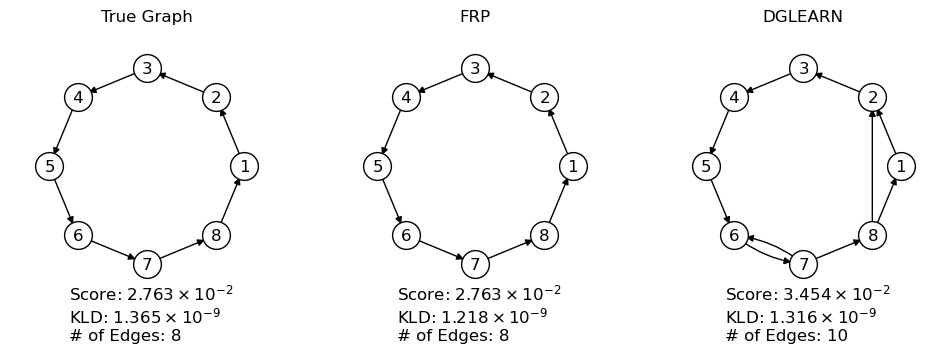

In [5]:
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    if not exponent:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits
    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

graph_frp = ig.Graph.Adjacency(frp_result["learned_support"]) # learned_support is the learned adjacency matrix
graph_dglearn = ig.Graph.Adjacency(dglearn_result["learned_support"])

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for ax_, graph in zip(ax, [graph_true, graph_frp, graph_dglearn]):
    plot_graph(ax_, graph, latex=False, node_size=400, node_color="white", edgecolors="k",
                labels={v: f"${v+1}$" for v in range(len(graph.vs))})
    adj = np.array(graph.get_adjacency().data)
    # Number of edges in the learned graph. |\hat{E}| in the paper.
    n_edges = adj.sum()
    # Minimum kld between the ground truth distribution and learned graph.
    # Corresponds to \mathcal{L}(\hat{E}, \Theta) in the paper.
    kld = minimize_kld(THETA, adj)[0] 
    score = kld + edge_penalty * n_edges
    ax_.text(-0.8, -1.5, "Score: {}\nKLD: {}\n# of Edges: {}".format(
                            sci_notation(score, decimal_digits=3), 
                            sci_notation(kld, decimal_digits=3),
                            n_edges),
                horizontalalignment='left',
                verticalalignment='center',
                fontsize=12)
    ax_.set_aspect("equal")                

ax[0].set_title("True Graph")
ax[1].set_title("FRP")
ax[2].set_title("DGLEARN")

plt.show()